* Faster RCNN by ChainerCV
* See,
    * https://arxiv.org/abs/1506.01497
    * https://github.com/chainer/chainercv/tree/master/examples/faster_rcnn

In [2]:
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import chainer
import chainercv
from chainercv.datasets import voc_bbox_label_names, VOCBboxDataset
from chainercv.visualizations import vis_bbox

In [4]:
dataset = VOCBboxDataset(year='2012')

From: http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
To: /root/.chainer/dataset/_dl_cache/92029705a99338d0932803388148a725
  %   Total    Recv       Speed  Time left
100 1907MiB 1907MiB   8154KiB/s    0:00:00

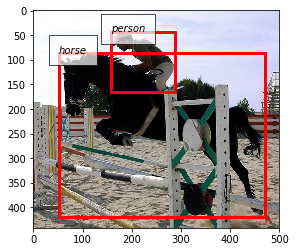

In [5]:
img, bbox, label = dataset[0]
vis_bbox(img, bbox, label, label_names=voc_bbox_label_names)
plt.show()

From: https://chainercv-models.preferred.jp/faster_rcnn_vgg16_voc0712_trained_2017_07_21.npz
To: /root/.chainer/dataset/_dl_cache/09ab0342dba3c4bbfb5f82e370d36bb5
  %   Total    Recv       Speed  Time left
100  486MiB  485MiB   8346KiB/s    0:00:00

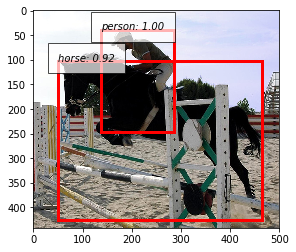

In [6]:
img, _, _ = dataset[0]
img = img[np.newaxis]
model = chainercv.links.FasterRCNNVGG16(pretrained_model='voc0712')
bboxes, labels, scores = model.predict(img)
vis_bbox(img[0], bboxes[0], labels[0], scores[0], label_names=voc_bbox_label_names)
plt.show()

In [3]:
from chainer.training import extensions
from chainercv import transforms
from chainercv.links.model.faster_rcnn import FasterRCNNTrainChain

In [4]:
class Transform(object):

    def __init__(self, faster_rcnn):
        
        self.faster_rcnn = faster_rcnn

    def __call__(self, in_data):
        
        img, bbox, label = in_data
        _, H, W = img.shape
        img = self.faster_rcnn.prepare(img)
        _, o_H, o_W = img.shape
        scale = o_H / H
        bbox = transforms.resize_bbox(bbox, (H, W), (o_H, o_W))

        # horizontally flip
        img, params = transforms.random_flip(img, x_random=True, return_param=True)
        bbox = transforms.flip_bbox(bbox, (o_H, o_W), x_flip=params['x_flip'])

        return img, bbox, label, scale

In [13]:
gpu = 0
iteration_num = 1 # 1000

faster_rcnn = chainercv.links.FasterRCNNVGG16(n_fg_class=len(voc_bbox_label_names), pretrained_model='imagenet')
faster_rcnn.use_preset('evaluate')
model = FasterRCNNTrainChain(faster_rcnn)

if gpu >= 0:
    chainer.cuda.get_device_from_id(gpu).use()
    model.to_gpu()

train_dataset = chainer.datasets.TransformDataset(VOCBboxDataset(year='2012', split='train'), Transform(faster_rcnn))
train_iter = chainer.iterators.SerialIterator(train_dataset, batch_size=1)

valid_dataset = VOCBboxDataset(year='2012', split='val')
valid_iter = chainer.iterators.SerialIterator(valid_dataset, batch_size=1, repeat=False, shuffle=False)
    
optimizer = chainer.optimizers.MomentumSGD(lr=1e-3, momentum=0.9)
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer_hooks.WeightDecay(rate=0.0005))

In [14]:
updater = chainer.training.updaters.StandardUpdater(train_iter, optimizer, device=gpu)
trainer = chainer.training.Trainer(updater, (iteration_num, 'iteration'), out='result')
#trainer.extend(extensions.snapshot_object(model.faster_rcnn, 'snapshot_model.npz'), trigger=(iteration_num, 'iteration'))
#trainer.extend(extensions.ExponentialShift('lr', 0.1), trigger=(step_size, 'iteration'))
log_interval = (1, 'iteration')
trainer.extend(chainer.training.extensions.observe_lr(), trigger=log_interval)
trainer.extend(extensions.LogReport(trigger=log_interval))
trainer.extend(
    extensions.PrintReport(['iteration', 'epoch', 'elapsed_time', 'lr', 'main/loss', 'main/roi_loc_loss', 'main/roi_cls_loss', 'main/rpn_loc_loss', 'main/rpn_cls_loss', 'validation/main/map']),
    trigger=log_interval
)
if extensions.PlotReport.available():
    trainer.extend(extensions.PlotReport(['main/loss'], file_name='loss.png', trigger=log_interval), trigger=log_interval)

trainer.extend(
    chainercv.extensions.DetectionVOCEvaluator(valid_iter, model.faster_rcnn, use_07_metric=True, label_names=voc_bbox_label_names),
    trigger=log_interval
)
trainer.extend(extensions.dump_graph('main/loss'))
trainer.run()

iteration   epoch       elapsed_time  lr          main/loss   main/roi_loc_loss  main/roi_cls_loss  main/rpn_loc_loss  main/rpn_cls_loss  validation/main/map
1           0           852.544       0.001       5.49236     0.335826           3.73587            0.611781           0.808887           0.000163185          


In [ ]:
img, _, _ = valid_dataset[0]
img = img[np.newaxis]
model.score_thresh = 0.18
bboxes, labels, scores = model.predict(img)
vis_bbox(img[0], bboxes[0], labels[0], scores[0], label_names=voc_bbox_label_names)
plt.show()

In [ ]:
valid_iter.reset()
evaluator = chainercv.extensions.DetectionVOCEvaluator(valid_iter, model, label_names=voc_bbox_label_names)
result = evaluator()
result